# Concentration of Lyman  Alpha Emitters. 
# Can we detect protoclusters with S-PLUS data?


## Introduction

The Southern Photometric Local Universe Survey (S-PLUS), when finished, will provide photometric information homogeneously of a large area of the almost unexploited south sky. Its observations in 12-bands allow us to perform a better unveiling of the characteristics of many sources. This configuration helps to compute exquisite star-galaxy-quasar classification and accurate photometric redshift estimates (photo-zs). As a result, S-PLUS is, at present, one of the best surveys to study galaxy evolution in different environments, such as the field, voids, groups, and galaxy clusters up to $z \sim 0.4$. However, the detection of structures at $z \gtrsim 0.5$ by using photo-zs is challenging, mainly due to the depth of these observations. 

An efficient way to select sources at high redshift accurately is by searching for emission-line galaxies. This technique requires narrow-band photometry and a couple of broadbands to measure the flux excess compared to the continuum. Hence, the S-PLUS photometric data is perfect to look for this type of object. Many structures at the peak of the cosmic star-formation epoch have been reported by analyzing the concentration of Lyman Alpha Emitters (Pentericci et al. 2000, Venemans et al. 2005, Harikane et al. 2019, among others). 

Recently, Spinoso et al. (2020) could recover the bright-end of the Lyman alpha emitters (LAEs) luminosity function at $2.0 \lesssim z \lesssim 3.3$ successfully, using J-PLUS data. This survey presents a similar configuration and depth of S-PLUS. Then, we can perform an equivalent technique to detect these high-z sources. Instead of computing the luminosity function, we can analyze the spatial distribution of LAEs to search for some (if any) concentrations, which could be signposts of protocluster of galaxies. 

In this notebook, we show how to select LAEs at $z \sim 2.37$, by using a similar approach to Spinoso et al. (2020). Here, we search these sources in S-PLUS iDR3 data, in particular observations of the DEEP2 field. In order to try to recover protoclusters of galaxies, we analyze the LAE candidate's spatial clustering by applying different methods. 

## Data and Sanity checks

In this directory, there are three catalogs, which we obtained from splus.cloud and SDSS casjobs. The former, "SPLUS_DEEP2_full.fits", corresponds to S-PLUS magnitudes with their respective errors and sky positions of all sources in the DEEP2 field ($\alpha = 352.103^{\circ}$, $\delta=-0.219^{\circ}$). We limited this sample by the PhotoFlags (clean photometry) in the three bands that we will use (J0410, g, and r) and magnitude error in the r-band lower than 0.2. On the other hand, "SDSS_zspec.csv" contains objects with spectroscopic information in the same field but in the Sloan Digital Sky Survey at $z = 2.37 \pm 0.015$.
Finally, "SPLUSxSDSS_spec_full.fits" is the cross-match between the latter two catalogs, by using TOPCAT.

We will use these datasets to compare our photometric information with those from spectroscopy. Also, we will test our method to recover the expected continuum in the J0410 band, which is crucial to our main goals!

In [420]:
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.cm import get_cmap
from astropy.table import Table
from matplotlib.colors import LogNorm, Normalize

rcParams["axes.linewidth"] = 1.7
rc("xtick", labelsize=17)
rc("ytick", labelsize=17)
rcParams["ytick.major.size"] = 1.7
rcParams["ytick.minor.size"] = 1.7
rcParams["xtick.major.size"] = 1.7
rcParams["xtick.minor.size"] = 1.7
rcParams["xtick.major.width"] = 1.7
rcParams["xtick.minor.width"] = 1.7
rcParams["ytick.major.width"] = 1.7
rcParams["ytick.minor.width"] = 1.7
rcParams["ytick.major.pad"] = 10
rcParams["xtick.major.pad"] = 10

### Magnitude distributions

Before doing anything, it is important to check the magnitude distribution of our selected sources. As well as the number of objects those were not detected in a certain band! 

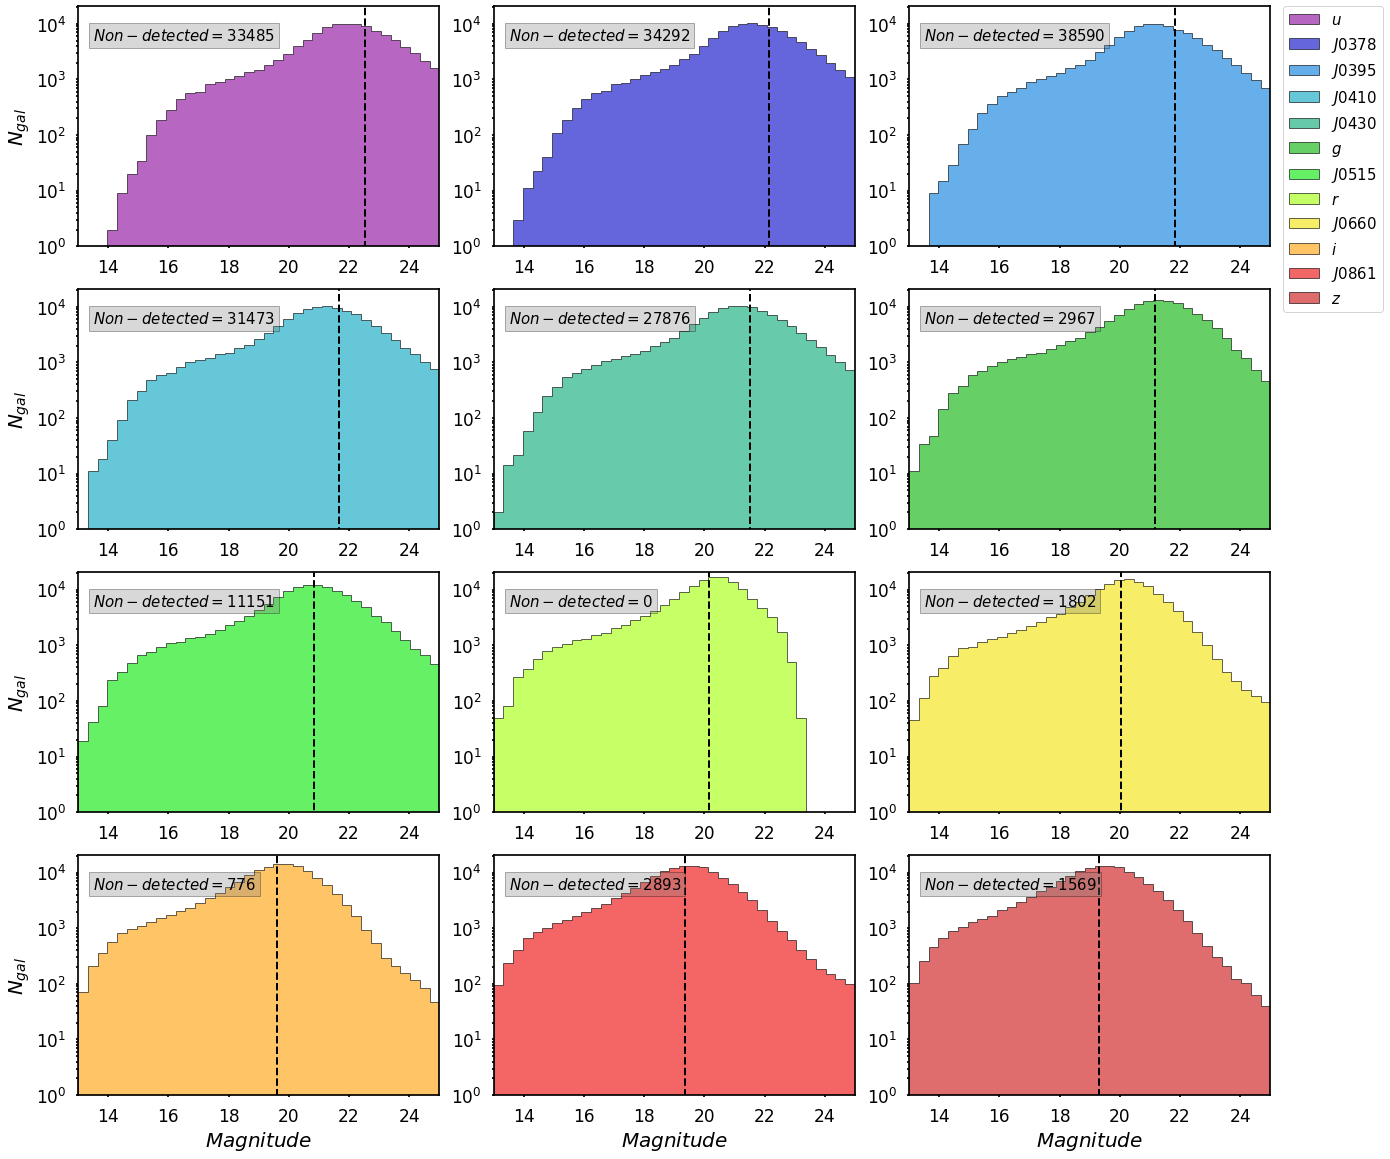

In [421]:
cat = fits.open("SPLUS_DEEP2_full.fits")[1].data
mag_names = ["u", "J0378", "J0395", "J0410", "J0430", "g", "J0515", "r", "J0660", "i", "J0861", "z"]
tmags = np.array([cat[mag_names[i]+"_auto"] for i in range(len(mag_names))]).T
tmags_e = np.array([cat["e_"+mag_names[i]+"_auto"] for i in range(len(mag_names))]).T

#### we will define a color for a certain photometric band
cmap = get_cmap("nipy_spectral")
c = np.linspace(0.1,0.95, 12)

bin_l, bin_u = 13., 25. 
bins_t = 3*(bin_u - bin_l) + 1
fig = plt.figure(figsize=(18,18))
fig.subplots_adjust(left=0.07, right=0.99, wspace=0.15, bottom=0.15, top=0.99, hspace=0.18)

for i in range(12):
    ax = fig.add_subplot(4, 3, i+1)
    ax.hist(tmags[:,i], bins=int(bins_t), range=(13, 25), histtype="stepfilled", facecolor=cmap(c[i]), edgecolor="black", 
            alpha=0.6, label=r"$"+mag_names[i]+"$")
    #ax.set_title(r"$"+mag_names[j][:-5]+"; \ z = "+str(redshift[b_5[i]])+"$", fontsize=15)
    ndet = np.sum(tmags[:,i] == 99) + np.sum(tmags[:,i] == -99)
    ax.set_xlim(13., 25)
    if i <= 11-3: pass #ax.set_xticks([])
    else: ax.set_xlabel(r"$Magnitude$", fontsize=20)
    if i%3 != 0: pass #ax.set_yticks([])
    else: ax.set_ylabel(r"$N_{gal}$", fontsize=20)
    ax.plot(2*[np.median(tmags[:,i])], [-0.1, 2.1e5], c="black", linewidth=2., linestyle="dashed")
    ax.text(13.5, 5e3, r"$Non-detected = "+str(ndet)+"$", fontsize=15, bbox=dict(facecolor='grey', alpha=0.3))
    #ax.text(13.5, 1900, r"$Non-detected = "+str(ndet)+"$", fontsize=15, bbox=dict(facecolor='grey', alpha=0.3))
    ax.set_yscale("log")
    ax.set_ylim(1, 2.05e4)
    
fig.legend(bbox_to_anchor=(1.0, 0.99), loc='upper left', borderaxespad=0., fontsize=15)

plt.show()

From the figure, we can see that the shallower band is J0395. Also, $31,473$ sources were not detected in the J0410 narrow band.
In addition to our previously sample selection criteria, we will reject sources as follow:
* Magnitude errors higher than 0.5 on the three photometric bands;
* Too faint and too bright sources (mag > 14 and mag < 24)

Now, we will check the spatial distribution:

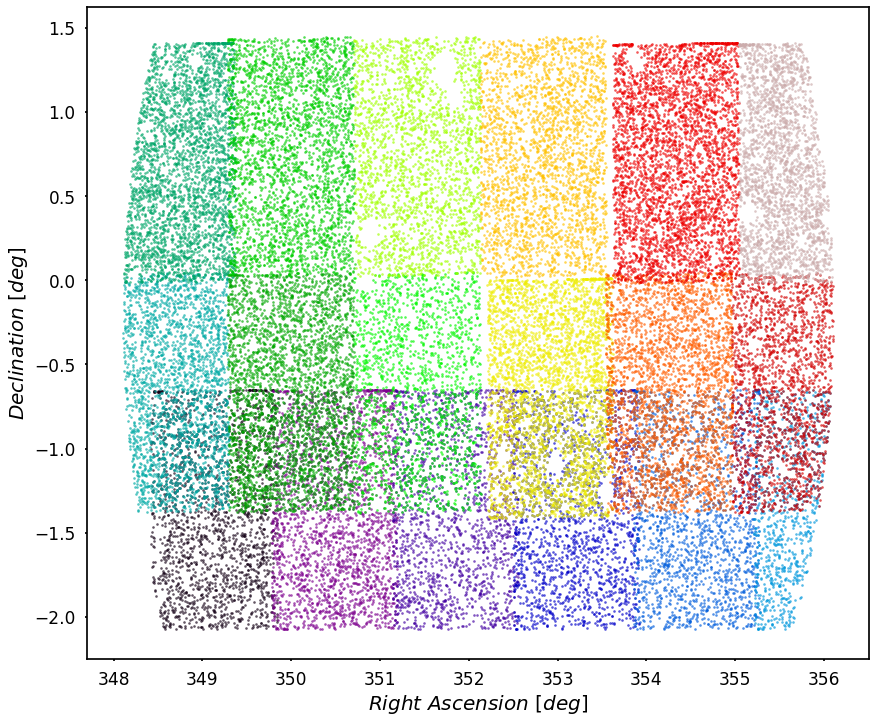

In [422]:
cat = fits.open("SPLUS_DEEP2_full.fits")[1].data

F3_mag = np.vstack([cat["J0410_auto"], cat["g_auto"], cat["r_auto"]]).T
F3_err = np.vstack([cat["e_J0410_auto"], cat["e_g_auto"], cat["e_r_auto"]]).T
### color coded by field name
field = cat["Field"]
ufield = np.unique(field)
field_color = np.linspace(0.01, 0.99, len(ufield))
clean = np.all(F3_err <= 0.5, axis=1) & np.all(F3_mag > 14, axis=1) & np.all(F3_mag < 24, axis=1)
plt.figure(figsize=(14,12))
for i in range(len(ufield)):
    plt.scatter(cat["RA"][clean&(field == ufield[i])], cat["DEC"][clean&(field == ufield[i])], 
                s=3, color=cmap(field_color[i]), alpha=0.5)
plt.xlabel(r"$Right \ Ascension \ [deg]$", fontsize=20)
plt.ylabel(r"$Declination \ [deg]$", fontsize=20)
plt.show()


As we can see, there are repeated sources observed by different fields, mainly at the edges. So, we need to be careful!   



### S-PLUS photometry and SDSS spectra

Now, we are going to compare S-PLUS photometry with spectroscopic information, which is crucial if we want to select LAEs. For this exercise, we use the "SPLUSxSDSS_spec.fits" catalog, which corresponds to a cross-match between S-PLUS and spectroscopically confirmed sources at $z\sim 2.37$. This is not a large sample (74) because of the low completeness of spectroscopic information. In general, most of these high-z confirmed objects are the brightest ones, in this case, just QSOs!.

In the following two cells, we download the spectrum of the 4th most luminous objects in the "SPLUSxSDSS_spec.fits" catalog:  

In [423]:
##### parameters to obtain SDSS spectra
scat = fits.open("SPLUSxSDSS_spec_full.fits")
scat = scat[1].data
survey = scat["survey"]
plate = scat["plate"].astype("str")
mjd = scat["mjd"].astype("str")
fiber = scat["fiberID"].astype("str")
mag_r = scat["r_auto"]
redshift = scat["z"]
url_boss = "https://data.sdss.org/sas/dr16/eboss/spectro/redux/v5_13_0/spectra/full/"
url_legacy = "https://data.sdss.org/sas/dr16/sdss/spectro/redux/26/spectra/"
url_segue = "https://data.sdss.org/sas/dr16/sdss/spectro/redux/104/spectra/"
mags = np.array([scat[mag_names[i]+"_auto"] for i in range(len(mag_names))]).T
mags_e = np.array([scat["e_"+mag_names[i]+"_auto"] for i in range(len(mag_names))]).T
##### fix prefixes
for i in range(len(mjd)):
    if len(plate[i]) == 3: plate[i] = "0"+plate[i]
    if len(fiber[i]) == 3: fiber[i] = "0"+fiber[i]

In [424]:
#### download spectra of the 5th brightest sources
b_4 = np.argsort(mag_r)
names = []
for i in range(4):
    name = plate[b_5[i]]+"/"+"spec-"+plate[b_5[i]]+"-"+mjd[b_5[i]]+"-"+fiber[b_5[i]]+".fits"
    names += [name[5:]]
    if os.path.exists(name[5:]) == False:
        if survey[b_5[i]] == "sdss": os.system("wget -nH "+url_legacy+name+" -O "+name[5:])
        elif survey[b_5[i]] == "segue1": os.system("wget -nH "+url_segue+name+" -O "+name[5:])
        else: os.system("wget -nH "+url_boss+name+" -O "+name[5:])

Now, we have the spectra of the 4th brightest sources. Let's make a check plot: spectra + S-PLUS photometry for these sources!
The Filtros directory constains the transmission curves, $T(\lambda)$, of the S-PLUS filters, whose names are listed in the {\it filtros.l} file. 

The effective wavelenght of a filter is defined as following:
$$ \lambda_{\rm eff} = \frac{\int T(\lambda) \lambda \ d\lambda}{\int T(\lambda) \ d\lambda} $$

For compare the S-PLUS photometry with our QSO spectra, we need to transform the magnitudes, $m$ into flux in $erg \ s^{-1} \ cm^{-1} \ \mathring{A} ^{-1}$ units. To do this, we will use the definition of AB magnitudes, then:

$$ f_{\lambda} = c \times \frac{10^{-0.4(m + 48.60)}}{\lambda_{eff}^2}$$ 
, where $c$ is the speed of light.

By error propagation, the flux error, $\sigma_f$ is:
$$ \sigma_f^2 = \left ( c \times \frac{0.4\ln{10}\times -10^{-0.4(m + 48.6)}}{\lambda_{eff}^2} \right )^2 \times \sigma_{mag}^2$$

where $\sigma_{mag}$ is the magnitude error.


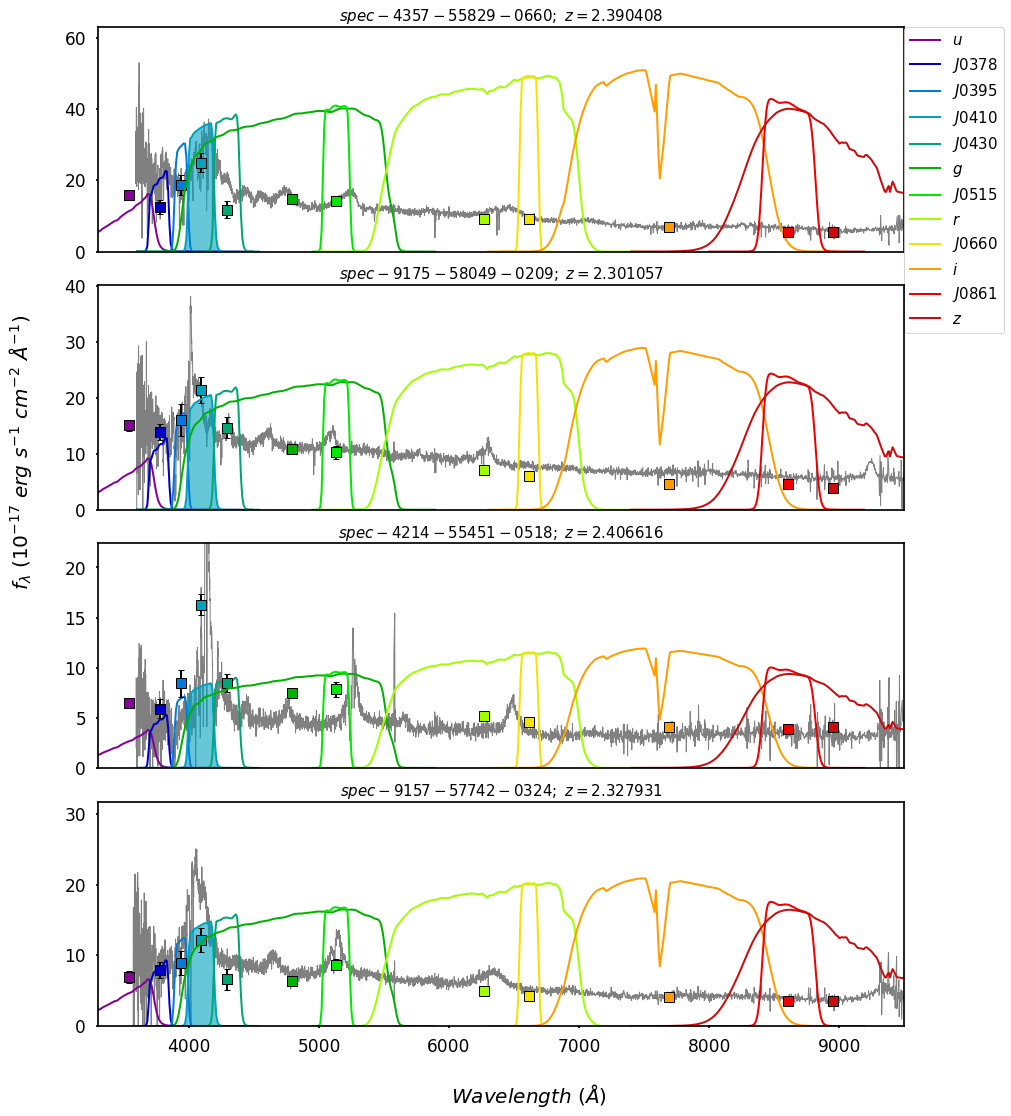

In [425]:
#### Filters
fnames = np.loadtxt("filtros.l", dtype="str")
ft = [np.loadtxt("Filtros/"+fnames[i]) for i in range(len(fnames))]
wl_eff = np.array([np.trapz(ft[i][:,0]*ft[i][:,1], ft[i][:,0])/np.trapz(ft[i][:,1], ft[i][:,0])
                   for i in range(len(fnames))])

##### fluxes and their erros from splus
sflux = 2.9979e18*10**(-0.4*(mags[b_5] + 48.60))/wl_eff**2
sflux_e = abs(2.9979e18*(0.4*np.log(10.)*(-10**(-0.4*(mags[b_5] + 48.6)))/wl_eff**2)*(mags_e[b_5]))


##### Figure

fig = plt.figure(figsize=(14,18))
fig.subplots_adjust(left=0.1, right=0.9, wspace=0.05, bottom=0.01, top=0.98, hspace=0.15)

for i in range(len(names)):
    hdu = fits.open(names[i])
    spec = hdu[1].data
    cols = spec.names
    hdu.close()
    wl, flux = 10**spec[cols[1]], spec[cols[0]]
    ax = fig.add_subplot(len(names)+1, 1, i+1)
    lup = flux[wl < 4000].max()
    ax.plot(wl, flux, c="grey", linewidth=1.0, zorder=-1)
    for j in range(len(fnames)): 
        color = cmap(c[j])
        if j == 3: 
            ax.fill_between(ft[j][:,0], 1.3*lup*ft[j][:,1], facecolor=color, alpha=0.6)
        ax.plot(ft[j][:,0], 1.3*lup*ft[j][:,1], c=color, linewidth=2., label=r"$"+mag_names[j]+"$")
        ax.errorbar(wl_eff[j], 1e17*sflux[i,j], yerr = 1e17*sflux_e[i,j], color="black", capsize=3, linewidth=2.)
        ax.plot(wl_eff[j], 1e17*sflux[i,j], marker="s", markersize=10, markerfacecolor=color, 
                markeredgecolor="black")
    ax.set_title(r"$"+names[i][:-5]+"; \ z = "+str(redshift[b_5[i]])+"$", fontsize=15)
    ax.set_xlim(3300, 9500)
    ax.set_ylim(0., lup+10)
    if i == 0: plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0., fontsize=15)
    if i < len(names)- 1: ax.set_xticks([])
fig.text(0.01, 0.55, r"$f_{\lambda} \ (10^{-17} \ erg \ s^{-1} \ cm^{-2} \  \AA^{-1})$", fontsize=20, rotation=90)
fig.text(0.45, 0.15, r"$Wavelength \ (\AA)$", fontsize=20)
plt.show()

The average fluxes at $\lambda_{\rm eff}$ of the sources, in major, match pretty well with their SDSS spectra, so, let's move on!

## Deriving the object continuum

Ok, now we will test our approach to find a function that describes the source continuum: 

We will follow the method presented in Spinoso et al. (2020). Basically, we have to use the information of two broad bands and a narrow one. One of the broad bands has to be contaminated by the Lyman $\alpha$ emission and the other with no flux contribution from Ly$\alpha$. We denote the former observed average flux as $\langle f_{\lambda}^{LC} \rangle$ and the latter as $\langle f_{\lambda}^{LU} \rangle$. Additionally, we refer to $\langle f_{\lambda}^{NB} \rangle$ the observed flux in the narrow-band.
The approximations are the following:
* We can trace with a linear function the continuum of the source between the wavelength range. Therefore, $f_\lambda^{cont} =  A\lambda + B$
* The Ly$\alpha$ emission can be approximated as a Dirac function centered, in this case, at $\lambda_{EL} = (1 + 2.25)\times1216 \mathring{A}$. Then, $f_{\lambda}^{EL} = F^{EL}\delta(\lambda - \lambda_{EL})$.

Consequently, the average flux in a certain band $x$, with transmission curve, $T_{\lambda}^x$, is:

$$ \langle f_{\lambda}^x \rangle = \frac{\int (A\lambda + B + f_{\lambda}^{EL})T_{\lambda}^x \lambda d\lambda}{\int T_{\lambda}^x \lambda d \lambda}$$ 

$$ \langle f_{\lambda}^x \rangle = \frac{A\int \lambda^2T_\lambda^x d \lambda +  B\int T_\lambda^x \lambda d \lambda + \int f_\lambda^{EL} T_\lambda^x \lambda d \lambda}{\int T_\lambda^x \lambda d \lambda}$$

Then:

$$ \langle f_{\lambda}^x \rangle = \frac{A\int \lambda^2T_\lambda^x d \lambda +  B\int T_\lambda^x \lambda d \lambda + F^{EL} T_{\lambda_{EL}}^x \lambda_{EL}}{\int T_\lambda^x \lambda d \lambda}$$.

We can write the last equation as follow:

$$ \langle f_{\lambda}^x \rangle = A \alpha_x + B + F^{EL}\beta_x$$

where, $\alpha_x$ and $\beta_x$ only depend on the transmission curve and $\lambda_{EL}$:

$$ \alpha_x = \frac{\int \lambda^2 T_\lambda^x d \lambda}{\int T_\lambda^x \lambda d \lambda}; \ \beta_x = \frac{T_{\lambda_{EL}}^x \lambda_{EL}}{\int T_\lambda^x \lambda d \lambda} $$

Finally, we need to solve the next system of equations to obtain the $A$, $B$ continuum coeficients and the Lyman $\alpha$ flux:
    $$\langle f_{\lambda}^{NB} \rangle = A \alpha_{NB} + B + F^{EL} \beta_{NB}$$
    $$\langle f_{\lambda}^{LC} \rangle = A \alpha_{LC} + B + F^{EL} \beta_{LC}$$        
    $$\langle f_{\lambda}^{LU} \rangle = A \alpha_{LU} + B $$

We obtained that:
$$ F^{EL} = \frac{\langle f_{\lambda}^{LC} \rangle - \langle f_{\lambda}^{LU} \rangle + \frac{\alpha_{LU} - \alpha_{LC}}{\alpha_{NB} - \alpha_{LU}}[\langle f_{\lambda}^{NB} \rangle- \langle f_{\lambda}^{LU} \rangle]}{\beta_{LC} + \frac{\alpha_{LU} - \alpha_{LC}}{\alpha_{NB} - \alpha_{LU}}\beta_{NB}} $$
$$ A = \frac{\langle f_{\lambda}^{NB} \rangle - \langle f_{\lambda}^{LU} \rangle - \frac{\beta_{NB}}{\beta_{LC}}[\langle f_{\lambda}^{LC} \rangle- \langle f_{\lambda}^{LU} \rangle]}{\alpha_{NB} - \alpha_{LU} - \frac{\beta_{NB}}{\beta_{LC}}(\alpha_{LC} - \alpha_{LU})} $$
$$ B = \langle f_{\lambda}^{LU} \rangle - \alpha_{LU}A $$

Now, let's implement this into the code:

In [426]:
def alpha_t(t):
    return np.trapz(t[:,1]*t[:,0]**2, t[:,0])/np.trapz(t[:,1]*t[:,0], t[:,0])

def beta_t(t):
    ly = 1216.*(1 + 2.37)
    return ly*np.interp(ly, t[:,0], t[:,1])/np.trapz(t[:,1]*t[:,0], t[:,0])

def A_param(F3_flux, alphas, betas):
    ''' Function that returns the A parameter from Spinoso et al. (2020), this is the inclination of the continuum
    F3_flux is an array of length (,3) with the information of the average flux (erg/s/cm^2/A) in the three 
    photometric bands. Then, F3_flux MUST be [F_NB, F_LC, F_LU], where F_NB is the flux of the source in the 
    narrow band. F_LC and F_LU are the average fluxes in the broad-band contaninated and uncontaminated with the 
    Lyman Alpha emission.
    alphas and betas are the arrays of length (,3) with the alpha and beta parameter for the three filters'''
    alpha_nb, alpha_lc, alpha_lu = alphas[0], alphas[1], alphas[2]
    beta_nb, beta_lc, beta_lu = betas[0], betas[1], betas[2]
    A = (F3_flux[0] - F3_flux[2] - (beta_nb/beta_lc)*(F3_flux[1] - F3_flux[2]))/(
        alpha_nb - alpha_lu - (beta_nb/beta_lc)*(alpha_lc - alpha_lu))
    return A

def B_param(F3_flux, alphas, betas):
    B = F3_flux[2] - alphas[2]*A_param(F3_flux, alphas, betas)
    return B

def F_ly(F3_flux, alphas, betas):
    alpha_nb, alpha_lc, alpha_lu = alphas[0], alphas[1], alphas[2]
    beta_nb, beta_lc = betas[0], betas[1]
    c = (alpha_lu - alpha_lc)/(alpha_nb - alpha_lu)
    return (F3_flux[1] - F3_flux[2] + c*(F3_flux[0] - F3_flux[2]))/(
        beta_lc + c*beta_nb)

def flux_a(wl_c, cont, t):
    f_t = np.interp(t[:,0], wl_c, cont)
    a = np.trapz(f_t*t[:,0]*t[:,1], t[:,0])
    b = np.trapz(t[:,0]*t[:,1], t[:,0])
    return a/b



We are going to construct the last figure again, but now, we will include the derived continuum!
Also, we will estimate the flux at the J0410 band without the contribution of Ly$\alpha$

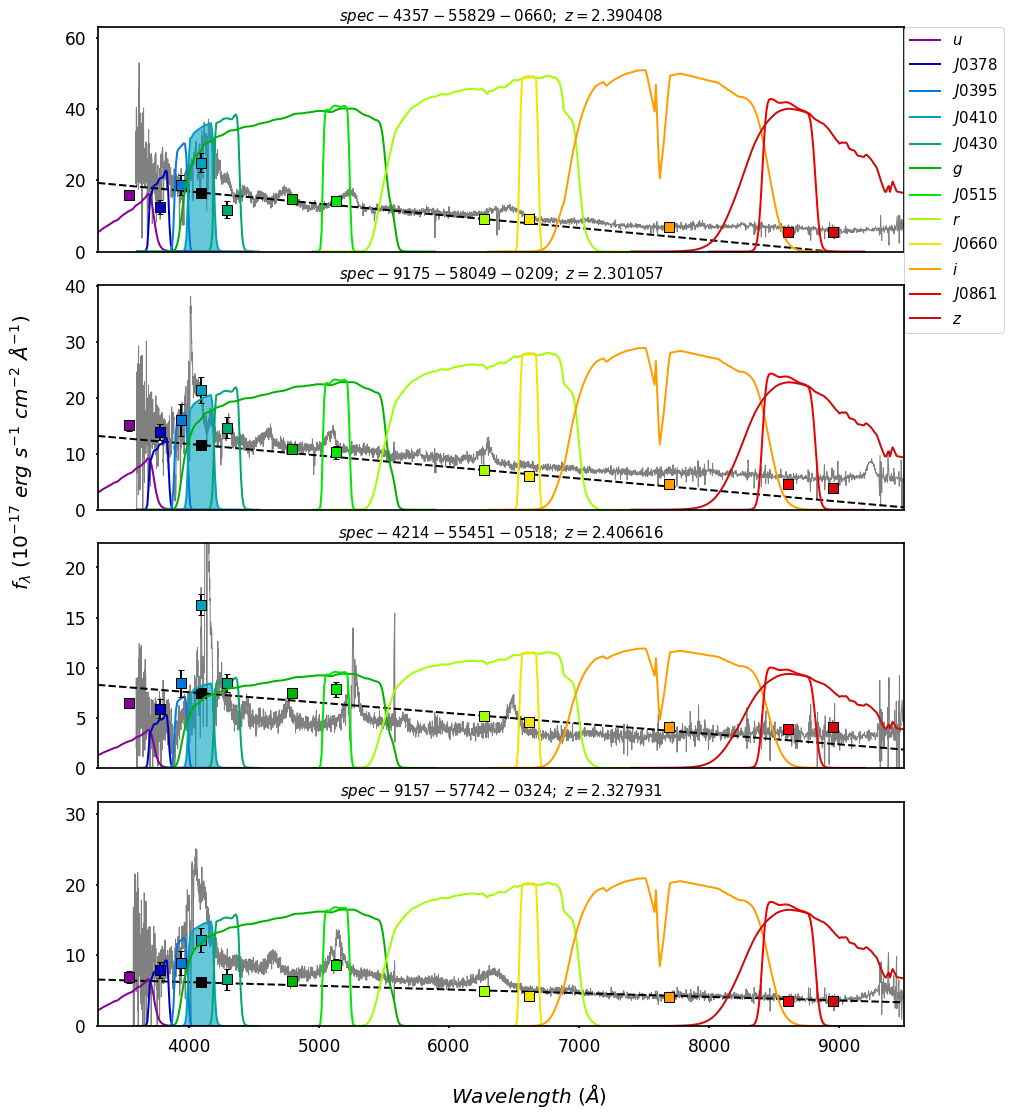

In [427]:
wl_c = np.linspace(3300, 9500, 1000)
### compute alpha and beta
trans = [ft[3], ft[5], ft[7]]
alphas = [alpha_t(i) for i in trans]
betas = [beta_t(i) for i in trans]

fig = plt.figure(figsize=(14,18))
fig.subplots_adjust(left=0.1, right=0.9, wspace=0.05, bottom=0.01, top=0.98, hspace=0.15)

for i in range(len(names)):
    hdu = fits.open(names[i])
    spec = hdu[1].data
    cols = spec.names
    hdu.close()
    wl, flux = 10**spec[cols[1]], spec[cols[0]]
    ax = fig.add_subplot(len(names)+1, 1, i+1)
    lup = flux[wl < 4000].max()
    ax.plot(wl, flux, c="grey", linewidth=1.0, zorder=-1)
    ##### plotting the derived continuum
    F3_flux = [sflux[i,3], sflux[i,5], sflux[i,7]]
    a_val = A_param(F3_flux, alphas, betas)
    b_val = B_param(F3_flux, alphas, betas)
    ax.plot(wl_c, 1e17*(a_val*wl_c + b_val), c="black", linestyle="dashed", linewidth=2.)
    ax.plot(wl_eff[3], 1e17*flux_a(wl_c, a_val*wl_c +b_val, trans[0]), marker="s", markersize=10, 
            markerfacecolor="black", markeredgecolor="black")
    for j in range(len(fnames)): 
        color = cmap(c[j])
        if j == 3: 
            ax.fill_between(ft[j][:,0], 1.3*lup*ft[j][:,1], facecolor=color, alpha=0.6)
        ax.plot(ft[j][:,0], 1.3*lup*ft[j][:,1], c=color, linewidth=2., label=r"$"+mag_names[j]+"$")
        ax.errorbar(wl_eff[j], 1e17*sflux[i,j], yerr = 1e17*sflux_e[i,j], color="black", capsize=3, linewidth=2.)
        ax.plot(wl_eff[j], 1e17*sflux[i,j], marker="s", markersize=10, markerfacecolor=color, 
                markeredgecolor="black")
    ax.set_title(r"$"+names[i][:-5]+"; \ z = "+str(redshift[b_5[i]])+"$", fontsize=15)
    ax.set_xlim(3300, 9500)
    ax.set_ylim(0., lup+10)
    if i == 0: plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0., fontsize=15)
    if i < len(names)- 1: ax.set_xticks([])
fig.text(0.01, 0.55, r"$f_{\lambda} \ (10^{-17} \ erg \ s^{-1} \ cm^{-2} \  \AA^{-1})$", fontsize=20, rotation=90)
fig.text(0.45, 0.15, r"$Wavelength \ (\AA)$", fontsize=20)
plt.show()

Cool! It seems that it worked.

## Full sample

Now, we will estimate the continuum magnitude in the J0410 band for the full catalog. 
As we have shown, some sources do not present information in the three input magnitudes. Therefore, we have to select a subsample with "clean" photometry. At this first step, we will reject all objects with: 
* Objects with magnitude errors higher than 0.5 in the three bands.

In some cases, we notice that the average flux of the derived J0410 continuum is negative. For these sources, the NB continuum magnitude is set as 24. (the maximum allowed magnitude).   

In [ ]:
F3_mag = np.vstack([cat["J0410_auto"], cat["g_auto"], cat["r_auto"]]).T
F3_err = np.vstack([cat["e_J0410_auto"], cat["e_g_auto"], cat["e_r_auto"]]).T
F3_wle = wl_eff[[3,5,7]]
F3_flux = 2.9979e18*10**(-0.4*(F3_mag + 48.60))/F3_wle**2 
F3_ferr = abs(2.9979e18*(0.4*np.log(10.)*(-10**(-0.4*(F3_mag + 48.6)))/F3_wle**2)*(F3_err))

clean = np.all(F3_err <= 0.5, axis=1) & np.all(F3_mag > 14, axis=1) & np.all(F3_mag < 24, axis=1)
#clean = clean & (F3_mag[:,0] <= np.median(F3_mag[:,0][F3_err[:,0] < 1./3]))

nb_c, f_ly = np.zeros(np.sum(clean)), np.zeros(np.sum(clean))
for i in range(np.sum(clean)):
    a_val = A_param(F3_flux[clean][i], alphas, betas)
    b_val = B_param(F3_flux[clean][i], alphas, betas)
    f_ly[i] = F_ly(F3_flux[clean][i], alphas, betas)
    flux_val = flux_a(wl_c, a_val*wl_c +b_val, trans[0])
    if flux_val > 0.: nb_c[i] =  -2.5*np.log10((flux_val*F3_wle[0]**2)/(2.9979e18)) - 48.60
    else: nb_c[i] = 24.

In [ ]:
##### Now for spectroscopically confirmed objects at z ~ 2.37

sF3_mag = np.vstack([scat["J0410_auto"], scat["g_auto"], scat["r_auto"]]).T
sF3_err = np.vstack([scat["e_J0410_auto"], scat["e_g_auto"], scat["e_r_auto"]]).T
sF3_flux = 2.9979e18*10**(-0.4*(sF3_mag + 48.60))/F3_wle**2 
sF3_ferr = abs(2.9979e18*(0.4*np.log(10.)*(-10**(-0.4*(sF3_mag + 48.6)))/F3_wle**2)*(sF3_err))

sclean = np.all(sF3_err <= 0.5, axis=1) & np.all(sF3_mag > 14, axis=1) & np.all(sF3_mag < 24, axis=1)
#sclean = sclean & (sF3_mag[:,0] <= np.median(sF3_mag[:,0][sF3_err[:,0] < 1./3]))

snb_c, sf_ly = np.zeros(np.sum(sclean)), np.zeros(np.sum(sclean))
for i in range(np.sum(sclean)):
    a_val = A_param(sF3_flux[sclean][i], alphas, betas)
    b_val = B_param(sF3_flux[sclean][i], alphas, betas)
    flux_val = flux_a(wl_c, a_val*wl_c +b_val, trans[0])
    if flux_val > 0.: snb_c[i] =  -2.5*np.log10((flux_val*F3_wle[0]**2)/(2.9979e18)) - 48.60
    else: snb_c[i] = 24.

The next step is define a criterium to select the LAEs. Spinoso et al. (2020) implemented two main criteria. The first one, linked to the minimum equivalent width defined as:
$$ (\Delta m^{NB})_{min} = 2.5\times \log(1 + \beta_{NB}EW_{0, min}(1+z)) + \langle \Delta m^{NB} \rangle$$

, where $\Delta m^{NB}$ is the ($J0410^{cont} - J0410$) color and $EW_{0,min}$ is the minimum equivalent width, which they set as 50 $\mathring{A}$. 

Additionally, we will exclude all sources fainter than the median $J0410$ magnitude + $0.1 \ [mag]$. 

Let's see this in a plot.


In [ ]:
##### let s see the figure
a_color = np.mean(nb_c - F3_mag[:,0][clean])

LAE_c =  nb_c - F3_mag[:,0][clean] >= 2.5*np.log10(1 + betas[0]*50*(1 + 2.37))
LAE_c = LAE_c & (F3_mag[:,0][clean] <= np.median(F3_mag[:,0][clean]) + 0.1)
plt.figure(figsize=(12,8))

plt.scatter(F3_mag[:,0][clean], nb_c - F3_mag[:,0][clean], s=6, color="dodgerblue", alpha=0.3)
plt.scatter(F3_mag[:,0][clean][LAE_c], (nb_c - F3_mag[:,0][clean])[LAE_c], s=6, color="limegreen", alpha=0.3)
plt.scatter(sF3_mag[:,0][sclean], (snb_c - sF3_mag[:,0][sclean]), s=7, color="black", marker="D")

plt.plot([13, np.median(F3_mag[clean][:,0]) + 0.1], 2*[2.5*np.log10(1 + betas[0]*50*(1 + 2.37))], c="red", linewidth=2., linestyle="dashed")
plt.plot(np.array(2*[np.median(F3_mag[clean][:,0])]) + 0.1, [-3,5], c="red", linewidth=2., linestyle="dashed")
plt.fill_between([np.median(F3_mag[clean][:,0]) + 0.1, 23.], [-3.,-3.],[6,6],  color="grey", alpha=0.3)

plt.xlim(14,22.5)
plt.ylim(-2.5, 5.0)
plt.xlabel(r"$J0410 \ [mag]$", fontsize=20)
plt.ylabel(r"$J0410^{cont} - J0410 \ [mag]$", fontsize=20)
plt.show()


The second selection criterium is based on the NB excess significance, considering the photometric errors. This part is not extensively explained in the paper. 

### NB excess significance
 Basically, we need to impose the next condition: 
$$\Delta m^{NB} > \Sigma \times \sigma_{\Delta m^{NB}} + \langle \Delta m^{NB} \rangle$$ 

Here, $\Sigma$ is set as 3 and $\sigma_{\Delta m^{NB}} = \sqrt{\sigma_{J0410^{cont}} + \sigma_{J0410}}$, where $\sigma_{J0410^{cont}}$ and $\sigma_{J0410}$ denote the error in the computed narrow-band continuum and the observed, respectively.
In principle, the last function is a continuum and appears to only depend on the $J0410$ magnitude. This is not entirely true since we have used three average fluxes to compute $J0410^{cont}$ magnitude. 

We will approximate this selection function as a combination of magnitude errors in the three filters. Then:
$$\sigma_{J0410^{cont}} = \sqrt{2(\sigma_g^2 + \sigma_r^2)}$$
(This is for just simplicity, we could do this better, sorry)


In [ ]:
err = np.sqrt(2*np.sum(F3_err[:,1:][clean]**2, axis=1) + F3_err[:,0][clean]**2)
nb_s = nb_c - F3_mag[:,0][clean] >= 3*err + a_color

plt.figure(figsize=(12,8))

plt.scatter(F3_mag[:,0][clean], nb_c - F3_mag[:,0][clean], s=6, color="dodgerblue", alpha=0.3)
plt.scatter(F3_mag[:,0][clean][LAE_c], (nb_c - F3_mag[:,0][clean])[LAE_c], s=6, color="limegreen", alpha=0.3)
plt.scatter(F3_mag[:,0][clean][LAE_c&nb_s], (nb_c - F3_mag[:,0][clean])[LAE_c&nb_s], s=6, color="purple", alpha=0.3)
plt.scatter(sF3_mag[:,0][sclean], (snb_c - sF3_mag[:,0][sclean]), s=7, color="black", marker="D")

plt.plot([13, np.median(F3_mag[clean][:,0]) + 0.1], 2*[2.5*np.log10(1 + betas[0]*50*(1 + 2.37))], c="red", linewidth=2., linestyle="dashed")
plt.plot(np.array(2*[np.median(F3_mag[clean][:,0])]) + 0.1, [-3,5], c="red", linewidth=2., linestyle="dashed")
plt.fill_between([np.median(F3_mag[clean][:,0]) + 0.1, 23.], [-3.,-3.],[6,6],  color="grey", alpha=0.3)

plt.xlim(14,22.5)
plt.ylim(-2.5, 5.0)
plt.xlabel(r"$J0410 \ [mag]$", fontsize=20)
plt.ylabel(r"$J0410^{cont} - J0410 \ [mag]$", fontsize=20)
plt.show()

Purple dots represent the selected sample of LAE candidates.
Notice that we do not have an estimation of contamination rates or completeness of our sample. Therefore, our findings are just a raw approximation.

## Spatial Distribution

Now, we will examine the spatial distribution of our LAEs sample:

In [ ]:
pos_LAEs = np.array([cat["RA"], cat["DEC"]]).T[clean][LAE_c&nb_s]
plt.figure(figsize=(12,12))
plt.scatter(pos_LAEs[:,0], pos_LAEs[:,1], s=10, c="dodgerblue")
plt.xlabel(r"$Right \ Ascension \ [deg]$", fontsize=20)
plt.ylabel(r"$Declination \ [deg]$", fontsize=20)

plt.show()

For some reason, many sources at the edges of the observed fields satisfy our rigorous selection criteria. This implies that our contamination rate is high. We will exclude all LAE candidates at the border (0.02 deg) of each field before the clustering analysis... 

In [ ]:
field = cat["Field"][clean]
ufield = np.unique(field)

edge = 0.02
pos = np.array([cat["RA"], cat["DEC"]]).T[clean]
cpos = np.ones(len(pos), "bool")
for i in range(len(ufield)):
    fpos = pos[field == ufield[i]]
    ra_min, ra_max = fpos[:,0].min(), fpos[:,0].max()
    dec_min, dec_max = fpos[:,1].min(), fpos[:,1].max()
    cpos[field==ufield[i]] = (fpos[:,0] > ra_min + edge) & (fpos[:,0] < ra_max - edge) & (fpos[:,1] > dec_min + edge) & (fpos[:,1] < dec_max - edge)

pos_LAEs = np.array([cat["RA"], cat["DEC"]]).T[clean][LAE_c&nb_s&cpos]
plt.figure(figsize=(12,12))
plt.scatter(pos_LAEs[:,0], pos_LAEs[:,1], s=10, c="dodgerblue")
plt.xlabel(r"$Right \ Ascension \ [deg]$", fontsize=20)
plt.ylabel(r"$Declination \ [deg]$", fontsize=20)

plt.show()    

It seems better now. Let's search for LAE spatial concentrations!
For this task, we will use three different methods to find "clusters" in the spatial distribution of LAE candidates:
* Kernel Density Estimator (KDE)
* Gaussian Mixture Model (GMM)
* Hierarchical clustering (HC)


In [ ]:
from astroML.clustering import HierarchicalClustering, get_graph_segments
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neighbors import KernelDensity
from astroML.plotting.tools import draw_ellipse

##### kernel density
Nx = 250
Ny = 250
xmin, xmax = 347.5, 356.5
ymin, ymax = -2.25, 1.5

Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                                np.linspace(ymin, ymax, Ny)))).T

kde = KernelDensity(0.1, kernel='gaussian')
log_dens = kde.fit(pos_LAEs).score_samples(Xgrid)
dens = pos_LAEs.shape[0] * np.exp(log_dens).reshape((Ny, Nx))


In [ ]:
##### Gaussian mixture model
N = np.arange(1, 10)
models = [None for n in N]
for i in range(len(N)):
    models[i] = GMM(n_components=N[i], max_iter=100, covariance_type="full")
    models[i].fit(pos_LAEs)

AIC = [m.aic(pos_LAEs) for m in models]
BIC = [m.bic(pos_LAEs) for m in models]
i_best = np.argmin(BIC)
gmm_best = models[i_best]

ind = np.argsort(gmm_best.weights_)[::-1]

In [ ]:
##### hierarchical clustering
n_neighbors = 5
edge_cutoff = 0.5
cluster_cutoff = 10
model = HierarchicalClustering(n_neighbors=n_neighbors, edge_cutoff=edge_cutoff,
                               min_cluster_size=cluster_cutoff)
model.fit(pos_LAEs)
print(" scale: %2g" % np.percentile(model.full_tree_.data,
                                        100 * edge_cutoff))
n_components = model.n_components_
labels = model.labels_
# Get the x, y coordinates of the beginning and end of each line segment
T_x, T_y = get_graph_segments(model.X_train_,
                              model.full_tree_)
T_trunc_x, T_trunc_y = get_graph_segments(model.X_train_,
                                          model.cluster_graph_)

ulabel = np.unique(labels)


print(len(ulabel))
label_color = np.linspace(0.01,0.99, len(ulabel))

In [ ]:
##### figure!
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9, hspace=0.1, wspace=0.1)
ax = fig.add_subplot(111)
#### kernel
ax.imshow(dens, origin='lower', aspect='auto', norm=Normalize(),
               extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.inferno)

#### GMM
for cnt, i in enumerate(ind[:N[i_best]]):
    mu = gmm_best.means_[i]
    C = gmm_best.covariances_[i]
    w = gmm_best.weights_[i]
    print(cnt, i, w)
    # the 20 most numerous clusters in blue
    if (cnt<20):
        draw_ellipse(mu, C, scales=[1.0], ax=ax, fc='none', lw=1.0, ec='white')

###### hierarchical
for i in range(len(ulabel)):
    if ulabel[i] != -1: 
        plt.scatter(pos_LAEs[:,0][labels == ulabel[i]], pos_LAEs[:,1][labels == ulabel[i]], s=10, 
                    color=cmap(label_color[i]))
plt.plot(T_trunc_x, T_trunc_y, color="white", lw=0.8)

#ax.set_xlim(xmin, xmax)
#ax.set_ylim(ymin, ymax)
plt.xlabel(r'$Right \ Ascension \ [deg]$', fontsize=20)
plt.ylabel(r'$Declination \ [deg]$', fontsize=20)

The three different methods gave us different positions of "clusters". 

In general, clusters traced by the Hierarchical clustering technique are at the peak of the Kernel Density maps. However, the GMM clusters tend to link the KDE density peaks, implying spatially larger structures. HC nor GMM could recovered an overdense peak at $\alpha \sim 350.7^{\circ}$ and $\delta \sim 0.5^{\circ}$.

Besides that, We have found some raw protocluster candidates!